In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import pandas as pd
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


## Loading the dataset

In [4]:
#load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify = np.array(y_train), random_state=42)
#one hot encoding target variables
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape) 

x_train:  (42500, 32, 32, 3) y_train:  (42500, 10)
x_val:  (7500, 32, 32, 3) y_val:  (7500, 10)
x_test:  (10000, 32, 32, 3) y_test:  (10000, 10)


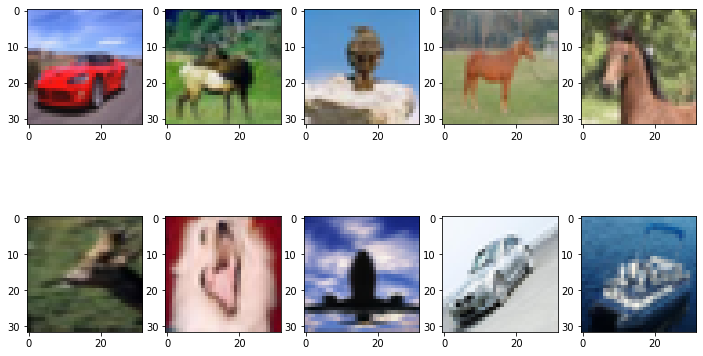

In [5]:
# plot first few images
fig = plt.figure(figsize=(12,7))
for i in range(10):
  # define subplot
	plt.subplot(2, 5, i+1)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

## Preprocessing data

VGG16 takes input images having minimum of 48 pixels of height and width. Therefore resizing the images

In [6]:
x_train = np.array([resize(x, (48, 48)) for x in x_train])
x_val = np.array([resize(x,(48, 48)) for x in x_val])
x_test = np.array([resize(x,(48, 48)) for x in x_test])
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape)

x_train:  (42500, 48, 48, 3) y_train:  (42500, 10)
x_val:  (7500, 48, 48, 3) y_val:  (7500, 10)
x_test:  (10000, 48, 48, 3) y_test:  (10000, 10)


## Preparing Model

In [7]:
batch_size= 32
epochs= 40
nb_classes= 10
learning_rate= 0.0001

In [8]:
base_model = vgg.VGG16(weights= 'imagenet', include_top= False, input_shape=(48,48,3))

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [10]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [11]:
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(nb_classes, activation='softmax')(x)
model = Model(base_model.input, pred)

In [12]:
for layer in base_model.layers:
     layer.trainable = False

In [18]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= learning_rate), metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

## Data Augmentation

In [20]:
train_data_gen = ImageDataGenerator(rescale = 1./255)
train_data_gen.fit(x_train)
train_generator = train_data_gen.flow(x_train, y_train, batch_size=batch_size)

In [21]:
validation_data_gen = ImageDataGenerator(rescale = 1./255)
validation_data_gen.fit(x_val)
validation_generator = validation_data_gen.flow(x_val, y_val, batch_size=batch_size)

## Training model

In [22]:

train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=epochs,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.2280 - accuracy: 0.9117 - val_loss: 0.2450 - val_accuracy: 0.9185
Epoch 2/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.2151 - accuracy: 0.9165 - val_loss: 0.2005 - val_accuracy: 0.9222
Epoch 3/40
1328/1328 [==============================] - 28s 21ms/step - loss: 0.2060 - accuracy: 0.9195 - val_loss: 0.1600 - val_accuracy: 0.9253
Epoch 4/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.2002 - accuracy: 0.9221 - val_loss: 0.1518 - val_accuracy: 0.9272
Epoch 5/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1944 - accuracy: 0.9241 - val_loss: 0.1398 - val_accuracy: 0.9281
Epoch 6/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1912 - accuracy: 0.9253 - val_loss: 0.1924 - val_accuracy: 0.9295
Epoch 7/40
1328/1328 [==============================] - 29s 22ms/step - loss: 0.1872 - accuracy: 0.9268 - val_loss: 0.1757 -

In [23]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

save_history(history, 'history_augmented.bin')
model.save('pre_trained_vgg16.h5')

## Model Performance

In [28]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

In [30]:
def load_history(fn):
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

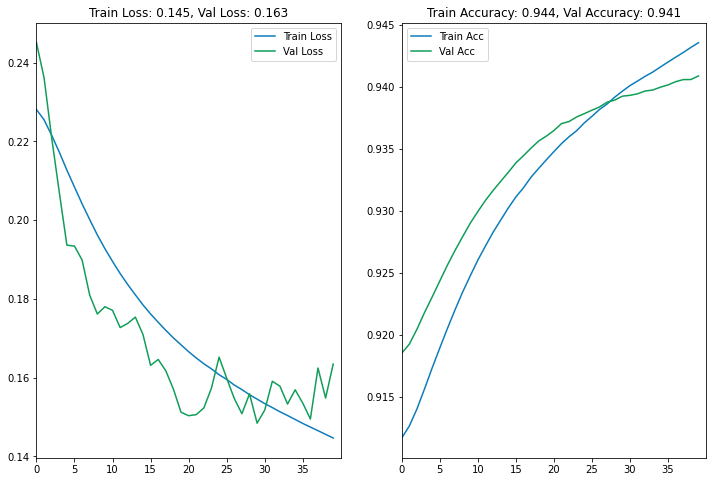

In [31]:
history = load_history('history_augmented.bin')
plot_compare(history)

## Predictions

In [32]:

predictions = model.predict(x_test/255.)

In [33]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}